In [1]:
from torch.utils.data.dataset import Dataset

import os
import torch
import fnmatch
import numpy as np
import pdb
import torchvision.transforms as transforms
from torchvision.models import mobilenetv3, ResNet50_Weights
from PIL import Image
import random
import torch.nn.functional as F
from loguru import logger

In [2]:
from torchvision.models.segmentation import (
    lraspp_mobilenet_v3_large,
    deeplabv3_resnet50,
    deeplabv3_mobilenet_v3_large,
)

In [15]:
trans_resnet = ResNet50_Weights.IMAGENET1K_V1.transforms()
trans_mobilenet = mobilenetv3.MobileNet_V3_Large_Weights.IMAGENET1K_V1.transforms()
trans_resnet, trans_mobilenet

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ),
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

[224]

In [13]:
fp = "segtrain_data/train/000000.npy"
with open(fp, "rb") as f:
    npzfile = np.load(f)
    input_data = npzfile["input"]  # (4, 256, 256) (C,H,W)
    output_data = npzfile["output"]  # (1, 256, 256) (C,H,W)

In [20]:
np.max(input_data2[1,:,:]), np.min(input_data2[-1,:,:])

(1.0, 0.0)

rgb: (5773, 11963, 3)


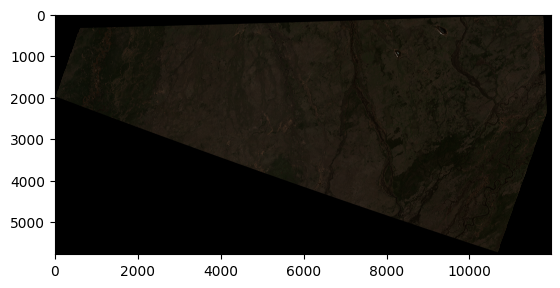

In [12]:
import rasterio
fp = "/scratch/workspace/rdaroya_umass_edu-water/segment-water-4band/swot-data/raw/20240520_203344_21_24af_3B_AnalyticMS_SR_clip.tif"
input_dataset = rasterio.open(fp)
input_data2 = input_dataset.read()   # (4, x, y) -- (C,H,W) - should be RGBA

input_data2 = input_data2/np.max(input_data2, axis=(1,2))[:,None,None]  # NOTE: Added for new raw planet data
tmp = input_data2[:3, :, :]
input_data2[:3, :, :] = tmp[::-1, :, :]
rgb = np.transpose(input_data2[:3, :, :], (1,2,0))
print(f"rgb: {rgb.shape}")
plt.imshow((rgb*255).astype(int))


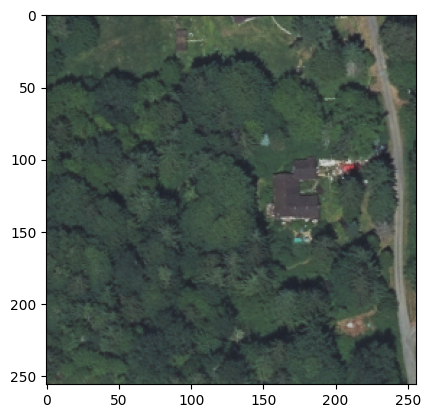

In [5]:
from matplotlib import pyplot as plt
rgb = np.transpose(input_data[:3, :, :], (1,2,0))
plt.imshow(rgb)

In [21]:
np.max(input_data), np.min(input_data)

(255, 23)

In [22]:
tmp = torch.from_numpy(input_data[:3, :, :]/255.)
tmp2 = trans(tmp)
torch.max(tmp2), torch.min(tmp2)

/home/rdaroya_umass_edu/miniconda3/envs/lsa/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(tensor(1.9428), tensor(-1.6042))

In [30]:
x = input_data[:3, :, :]
# x = (x-np.mean(x, axis=(1,2)).reshape(-1,1,1))/np.var(x, axis=(1,2)).reshape(-1,1,1)
x.shape, np.max(x), np.min(x), np.mean(x, axis=(1,2))

((3, 256, 256), 220, 30, array([63.35630798, 77.28466797, 68.68429565]))

In [20]:
tmp = torch.from_numpy(input_data[:3, :, :])
tmp2 = trans(tmp)


/home/rdaroya_umass_edu/miniconda3/envs/lsa/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(tensor(1.9428), tensor(-1.6042))

In [50]:
class SatelliteDataRGB(Dataset):
    """
    This file is directly modified from https://pytorch.org/docs/stable/torchvision/datasets.html
    """
    def __init__(self, root, split='train', transforms=None):
        self.split = split
        self.root = os.path.expanduser(root)
        self.transforms = transforms

        # R\read the data file
        if split=="train":
            self.data_path = os.path.join(root, 'train')
        elif split=="val":
            self.data_path = os.path.join(root, 'val')
        elif split=="test":
            self.data_path = os.path.join(root, 'test')
        else:
            raise NotImplementedError

        # calculate data length
        self.fps = fnmatch.filter(os.listdir(self.data_path), '*.npy')
        self.data_len = len(self.fps)
        # self.data_len = 20

    def __getitem__(self, index):
        # fp = os.path.join(self.data_path, f"{index:06d}.npy")
        fp = os.path.join(self.data_path, self.fps[index])
        with open(fp, "rb") as f:
            npzfile = np.load(f)
            input_data = npzfile["input"]  # (4, 256, 256) (C,H,W)
            output_data = npzfile["output"]  # (1, 256, 256) (C,H,W)
        
        image = torch.from_numpy(input_data[:3,:,:])
        label = torch.from_numpy(output_data)
        if self.transforms is not None:
            crop_size = self.transforms.__dict__["crop_size"][0]
            image = image[:, :crop_size, :crop_size]
            label = label[:, :crop_size, :crop_size]
            image = self.transforms(image)
            
        return (
            image.type(torch.FloatTensor),
            label.type(torch.FloatTensor),
        )

    def __len__(self):
        return self.data_len



In [51]:
trans = trans
train_dataset = SatelliteDataRGB(root="segtrain_data", split="train", transforms=trans)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=12,
    shuffle=True, num_workers=0)

In [52]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

/home/rdaroya_umass_edu/miniconda3/envs/lsa/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([12, 3, 224, 224]) torch.Size([12, 1, 224, 224])
